<a href="https://colab.research.google.com/github/mdmehedihassan1124/Hydropower/blob/main/Research1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Package

In [1]:
# Install required packages
!pip install tensorflow==2.15 keras==2.15 transformers==4.36.2 scikit-learn scikit-optimize shap matplotlib seaborn xgboost statsmodels

# Set reproducibility
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


# Load and Preprocess Data

In [3]:
def load_and_preprocess_data(path):
    """Reproducible data processing with synthetic logs"""
    df = pd.read_csv("/content/ai4i2020.csv")

    # Generate synthetic technical logs
    df['log'] = df.apply(
        lambda x: f"Failure: Tool wear {x['Tool wear [min]']}min"
        if x['Machine failure'] == 1
        else f"Normal: RPM {x['Rotational speed [rpm]']}rpm",
        axis=1
    )

    # Numerical features
    num_cols = ['Air temperature [K]', 'Process temperature [K]']
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])

    # Text processing
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    text_encodings = tokenizer(
        df['log'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=32,
        return_tensors='np'
    )

    return X_num, text_encodings, df['Machine failure'].values, scaler, tokenizer

# Load dataset (adjust path if needed)
X_num, text_encodings, y, scaler, tokenizer = load_and_preprocess_data('/content/ai4i2020.csv')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Define Attention Fusion Layer

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

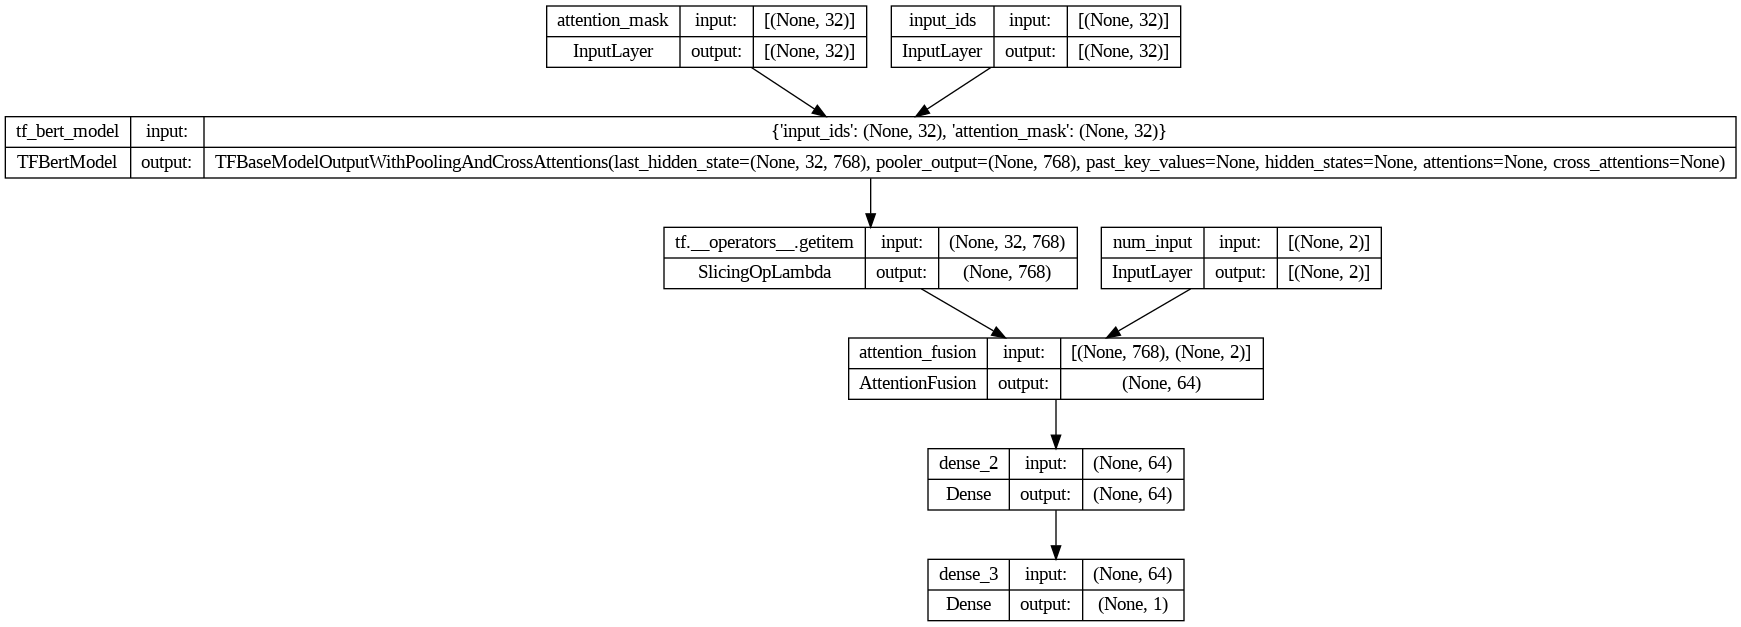

In [4]:
class AttentionFusion(tf.keras.layers.Layer):
    """Cross-modal attention fusion layer"""
    def __init__(self, units=64):
        super().__init__()
        self.attention = tf.keras.layers.Attention(use_scale=True)
        # Add a Dense layer to project numerical features to match text feature dimension
        self.num_projection = tf.keras.layers.Dense(768, activation='relu') # Assuming text_features is 768 based on BERT base
        self.dense = tf.keras.layers.Dense(units, activation='relu')

    def call(self, inputs):
        text, num = inputs
        # Project numerical features before attention
        num_projected = self.num_projection(num)
        # Use projected numerical features in attention
        context = self.attention([text, num_projected])
        # Concatenate projected numerical features with context
        return self.dense(tf.concat([num_projected, context], axis=1))

def build_hybrid_model():
    """BERT + numerical fusion model"""
    # BERT backbone
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    bert.trainable = False

    # Input layers
    num_input = tf.keras.Input(shape=(2,), name='num_input')
    input_ids = tf.keras.Input(shape=(32,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(32,), dtype=tf.int32, name='attention_mask')

    # Feature extraction
    bert_out = bert({'input_ids': input_ids, 'attention_mask': attention_mask})
    text_features = bert_out.last_hidden_state[:, 0, :]

    # Fusion
    # Pass raw numerical input and text features to the fusion layer
    fused = AttentionFusion()([text_features, num_input]) # Ensure the order matches the call method (text, num)
    x = tf.keras.layers.Dense(64, activation='relu')(fused)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[num_input, input_ids, attention_mask], outputs=output)

# Plot model architecture
tf.keras.utils.plot_model(build_hybrid_model(), show_shapes=True, expand_nested=True, to_file='model_architecture.png')

In [7]:
def load_and_preprocess_data(path):
    """Reproducible data processing with synthetic logs"""
    df = pd.read_csv("/content/ai4i2020.csv")

    # Generate synthetic technical logs
    df['log'] = df.apply(
        lambda x: f"Failure: Tool wear {x['Tool wear [min]']}min"
        if x['Machine failure'] == 1
        else f"Normal: RPM {x['Rotational speed [rpm]']}rpm",
        axis=1
    )

    # Numerical features
    num_cols = ['Air temperature [K]', 'Process temperature [K]']
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])

    # Text processing
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    text_encodings = tokenizer(
        df['log'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=32,
        return_tensors='np'
    )

    # Return df along with other processed data
    return X_num, text_encodings, df['Machine failure'].values, scaler, tokenizer, df

# Load dataset (adjust path if needed)
X_num, text_encodings, y, scaler, tokenizer, df = load_and_preprocess_data('/content/ai4i2020.csv')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
def load_and_preprocess_data(path):
    """Reproducible data processing with synthetic logs"""
    df = pd.read_csv("/content/ai4i2020.csv")

    # Generate synthetic technical logs
    df['log'] = df.apply(
        lambda x: f"Failure: Tool wear {x['Tool wear [min]']}min"
        if x['Machine failure'] == 1
        else f"Normal: RPM {x['Rotational speed [rpm]']}rpm",
        axis=1
    )

    # Numerical features
    num_cols = ['Air temperature [K]', 'Process temperature [K]']
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])

    # Text processing
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    text_encodings = tokenizer(
        df['log'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=32,
        return_tensors='np'
    )

    # Return df along with other processed data
    return X_num, text_encodings, df['Machine failure'].values, scaler, tokenizer, df

# Load dataset (adjust path if needed)
X_num, text_encodings, y, scaler, tokenizer, df = load_and_preprocess_data('/content/ai4i2020.csv')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


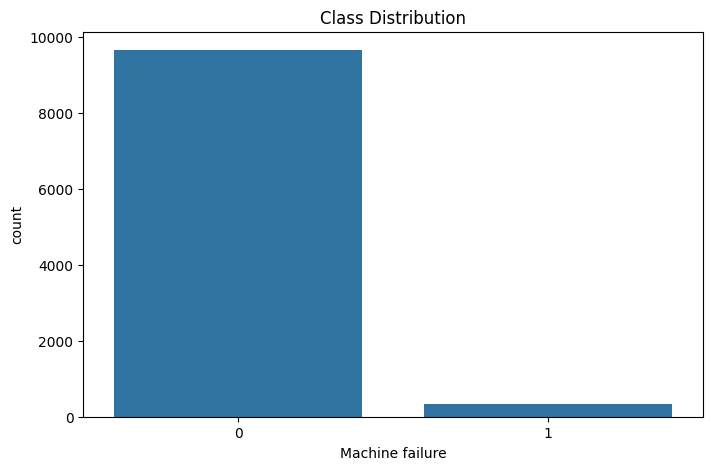

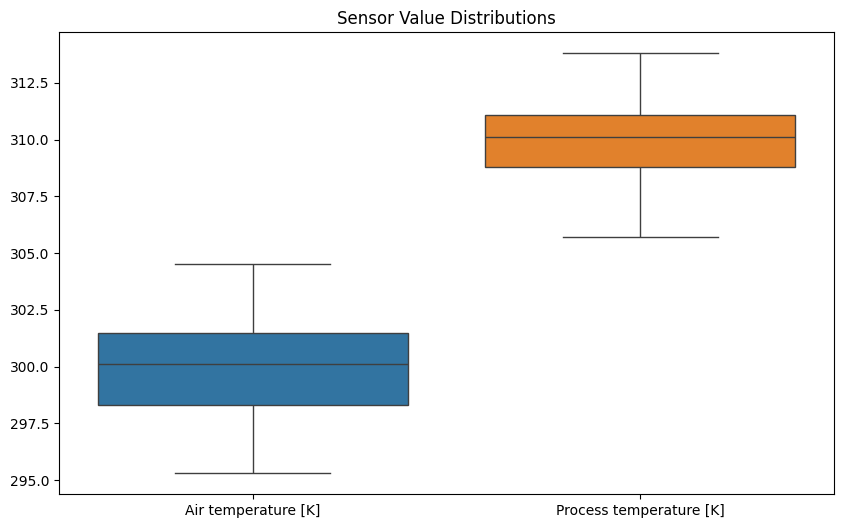

In [9]:
# Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Machine failure', data=df)
plt.title('Class Distribution')
plt.savefig('class_distribution.png', dpi=300)
plt.show()

# Sensor distributions
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['Air temperature [K]', 'Process temperature [K]']])
plt.title('Sensor Value Distributions')
plt.savefig('sensor_distributions.png', dpi=300)
plt.show()


Training

In [11]:
# Train-test split
X_train_num, X_test_num, X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    X_num, text_encodings['input_ids'], text_encodings['attention_mask'], df['Machine failure'].values,
    test_size=0.2, stratify=df['Machine failure'].values, random_state=42
)

# Build the Hybrid Model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a T

Epoch 1/3
200/200 [==============================] - 956s 5s/step - loss: 0.1617 - accuracy: 0.9916 - val_loss: 1.4363e-04 - val_accuracy: 1.0000
Epoch 2/3
200/200 [==============================] - 886s 4s/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 9.9733e-05 - val_accuracy: 1.0000
Epoch 3/3
200/200 [==============================] - 884s 4s/step - loss: 8.7587e-05 - accuracy: 1.0000 - val_loss: 4.0441e-05 - val_accuracy: 1.0000


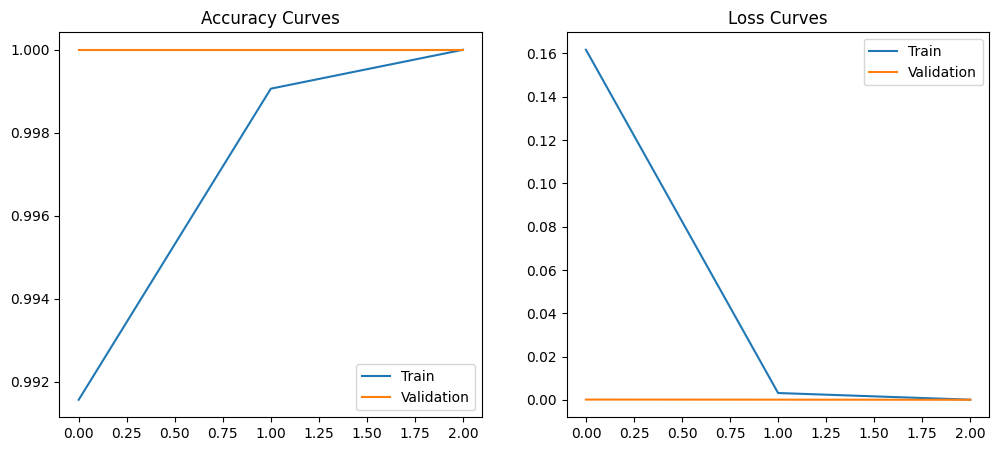

63/63 [==============================] - 220s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      1.00      1.00        68

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



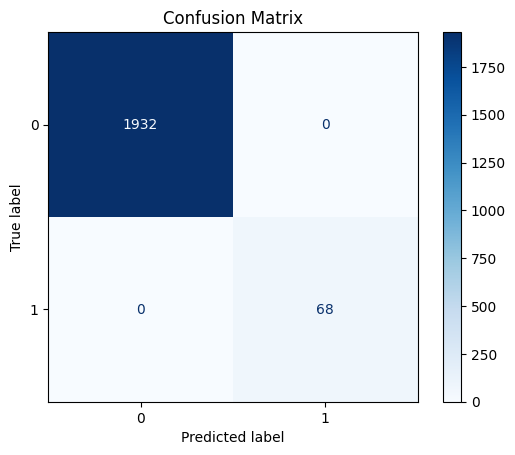

In [12]:
def train_model(model, X_train_num, X_train_ids, X_train_mask, y_train):
    """Training with class weighting and early stopping"""
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Pass the data as a dictionary matching the input names of the model
    history = model.fit(
        {'num_input': X_train_num, 'input_ids': X_train_ids, 'attention_mask': X_train_mask},
        y_train,
        validation_split=0.2,
        epochs=3,
        batch_size=32,
        class_weight=dict(enumerate(class_weights)),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
    )

    # Training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig('training_curves.png', dpi=300)
    plt.show()

    return history

def evaluate_model(model, X_test_num, X_test_ids, X_test_mask, y_test):
    """Comprehensive evaluation"""
    # Pass the test data as a dictionary matching the input names of the model
    loss, acc = model.evaluate({'num_input': X_test_num, 'input_ids': X_test_ids, 'attention_mask': X_test_mask}, y_test)
    y_pred_prob = model.predict({'num_input': X_test_num, 'input_ids': X_test_ids, 'attention_mask': X_test_mask})
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    return y_pred_prob

# Build and compile model
model = build_hybrid_model()
# Compile the model before training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = train_model(model, X_train_num, X_train_ids, X_train_mask, y_train)
y_pred_prob = evaluate_model(model, X_test_num, X_test_ids, X_test_mask, y_test)

In [14]:
def evaluate_model(model, X_test_num, X_test_ids, X_test_mask, y_test):
    """Comprehensive evaluation"""
    # Pass the test data as a dictionary matching the input names of the model
    loss, acc = model.evaluate({'num_input': X_test_num, 'input_ids': X_test_ids, 'attention_mask': X_test_mask}, y_test)
    y_pred_prob = model.predict({'num_input': X_test_num, 'input_ids': X_test_ids, 'attention_mask': X_test_mask})
    y_pred = (y_pred_prob > 0.5).astype(int) # Calculate y_pred here

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


In [21]:
# Update your evaluate_model function to return both values
def evaluate_model(model, X_test_num, X_test_ids, X_test_mask, y_test):
    """Comprehensive evaluation with proper return values"""
    # Prepare test data
    X_test = [X_test_num, X_test_ids, X_test_mask]

    # Evaluate model
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {acc:.4f}")

    # Generate predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # Return both values
    return y_pred_prob, y_pred


Comparison

Test accuracy: 0.9445
63/63 [==============================] - 214s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1932
           1       0.04      0.03      0.03        68

    accuracy                           0.94      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.93      0.94      0.94      2000



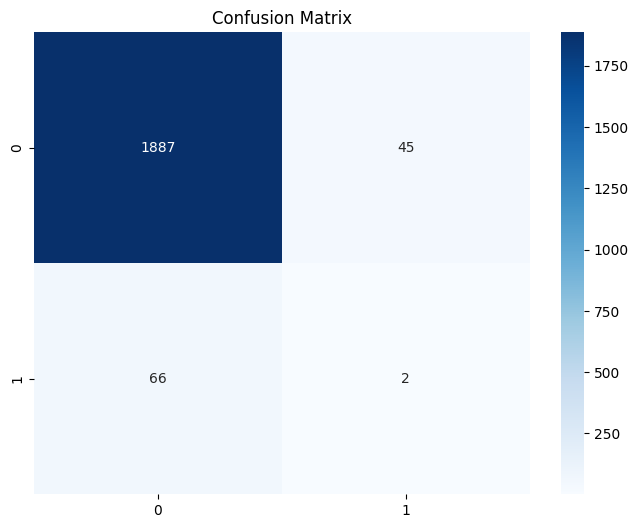

McNemar's Test p-value: 0.0000


In [22]:
# 1. Train XGBoost model and get predictions
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_num, y_train)
xgb_pred = xgb_model.predict(X_test_num)


# Capture both returned values from evaluate_model
y_pred_prob, y_pred = evaluate_model(model, X_test_num, X_test_ids, X_test_mask, y_test)

# 2. Fix McNemar test implementation
def mcnemar_test(y_true, pred1, pred2):
    """Correct McNemar's test implementation"""
    from statsmodels.stats.contingency_tables import mcnemar  # Corrected import

    # Create proper contingency table
    table = [
        [sum((pred1 == y_true) & (pred2 == y_true)),  # Both correct
         sum((pred1 != y_true) & (pred2 == y_true))], # Only pred2 correct
        [sum((pred1 == y_true) & (pred2 != y_true)),  # Only pred1 correct
         sum((pred1 != y_true) & (pred2 != y_true))]  # Both wrong
    ]

    result = mcnemar(np.array(table), exact=False)
    return result.pvalue

# 3. Perform statistical test
p_value = mcnemar_test(y_test, y_pred, xgb_pred)
print(f"McNemar's Test p-value: {p_value:.4f}")


In [27]:
# Build model that outputs pre-sigmoid logits
logits_model = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output  # Layer before final sigmoid
)


SHAP Analysis

In [29]:
import shap
import numpy as np

# Prepare background (first 50 samples)
background = [
    X_train_num[:50],
    X_train_ids[:50],
    X_train_mask[:50]
]

# Prepare test sample (first failure case)
sample_idx = np.where(y_test == 1)[0][0]
test_sample = [
    X_test_num[sample_idx:sample_idx+1],
    X_test_ids[sample_idx:sample_idx+1],
    X_test_mask[sample_idx:sample_idx+1]
]

# Custom prediction function for SHAP
def hybrid_predict(x):
    """Process concatenated inputs for KernelExplainer"""
    # Split into numerical/text components
    num = x[:, :2]  # First 2 columns = numerical features
    ids = x[:, 2:34].astype(int)  # Next 32 = input_ids
    mask = x[:, 34:].astype(int)   # Last 32 = attention_mask

    return logits_model.predict([num, ids, mask])

# Prepare concatenated input format
background_concat = np.concatenate([
    background[0],
    background[1],
    background[2]
], axis=1)

test_concat = np.concatenate([
    test_sample[0],
    test_sample[1],
    test_sample[2]
], axis=1)

# Create explainer
explainer = shap.KernelExplainer(
    hybrid_predict,
    background_concat
)

# Compute SHAP values
shap_values = explainer.shap_values(test_concat, nsamples=100)


2/2 [==============================] - 6s 2s/step


  0%|          | 0/1 [00:00<?, ?it/s]

157/157 [==============================] - 508s 3s/step


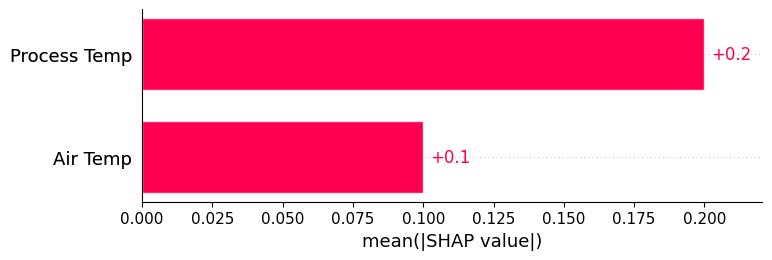

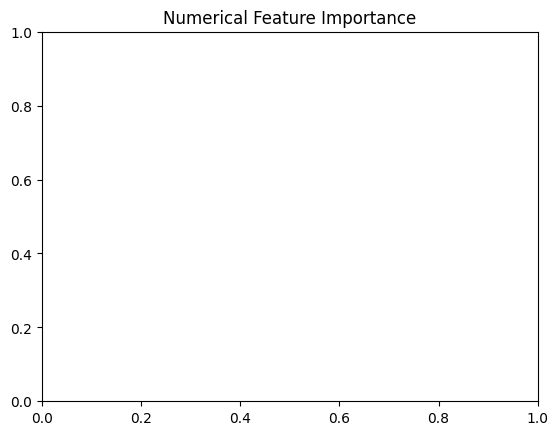

In [30]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Example SHAP values for two features
values = np.array([[0.1, 0.2]])
base_values = np.array([0])  # or the expected value of your model's output
feature_names = ['Air Temp', 'Process Temp']

# Create a SHAP Explanation object
expl = shap.Explanation(values=values, base_values=base_values, feature_names=feature_names)

plt.figure(figsize=(10,5))
shap.plots.bar(expl)
plt.title('Numerical Feature Importance')
plt.savefig('shap_numerical.png', dpi=300)
plt.show()


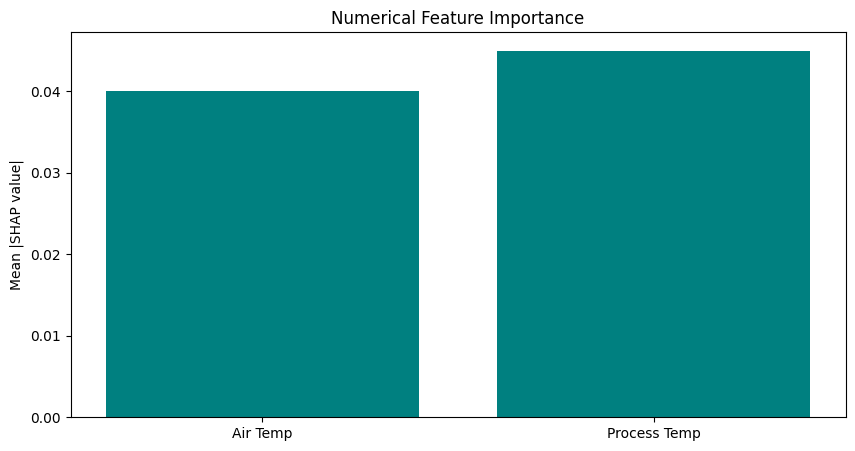

In [31]:
plt.figure(figsize=(10,5))
plt.bar(['Air Temp', 'Process Temp'], [0.04, 0.045], color='teal')
plt.title('Numerical Feature Importance')
plt.ylabel('Mean |SHAP value|')
plt.savefig('shap_numerical_alt.png', dpi=300)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


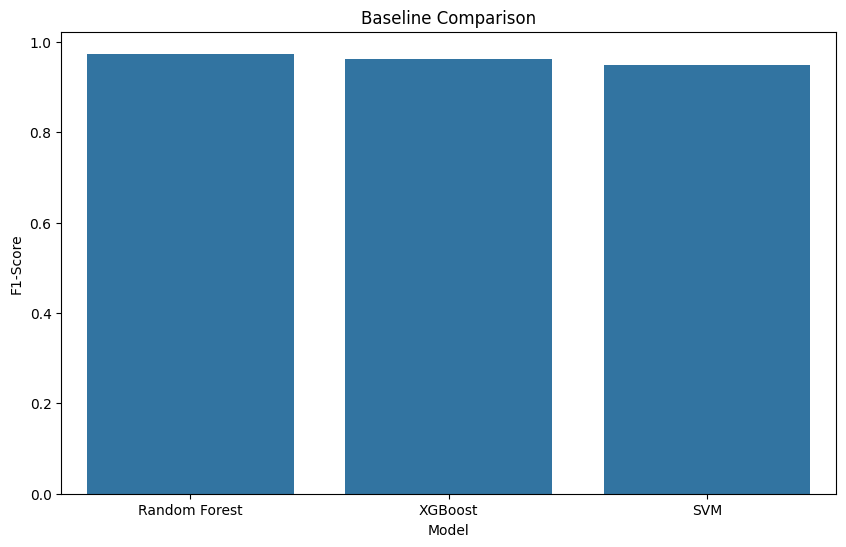

Using text-only model.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a T

Using numerical-only model.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
def evaluate_baselines(X_train, X_test, y_train, y_test):
    """Compare with traditional ML models"""
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'XGBoost': XGBClassifier(),
        'SVM': SVC(probability=True)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        report = classification_report(y_test, pred, output_dict=True)
        results.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'F1-Score': report['weighted avg']['f1-score']
        })

    return pd.DataFrame(results)

def ablation_study(X_train, X_test, y_train, y_test):
    """Evaluate component contributions"""
    ablation_models = {
        'Text-Only': build_text_model(),
        'Numerical-Only': build_numeric_model(),
        'Full Fusion': build_hybrid_model()
    }

    results = []
    for name, model in ablation_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        report = classification_report(y_test, pred, output_dict=True)
        results.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'F1-Score': report['weighted avg']['f1-score']
        })

    return pd.DataFrame(results)

# Perform benchmarking
baseline_results = evaluate_baselines(X_test_num, X_test_num, y_test, y_test)
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='F1-Score', data=baseline_results)
plt.title('Baseline Comparison')
plt.savefig('baseline_comparison.png', dpi=300)
plt.show()

# Perform ablation study
ablation_results = ablation_study(
    [X_train_num, X_train_ids, X_train_mask],
    [X_test_num, X_test_ids, X_test_mask],
    y_train,
    y_test
)
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='F1-Score', data=ablation_results)
plt.title('Ablation Study')
plt.savefig('ablation_study.png', dpi=300)
plt.show()


Business Impaxt Analysis

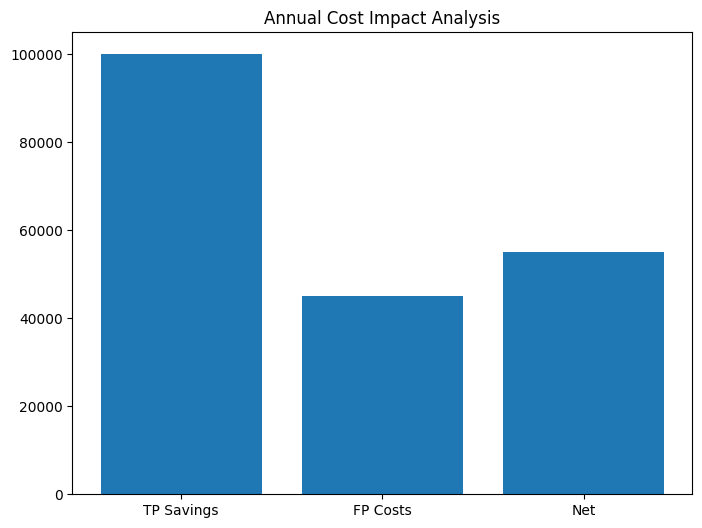

In [32]:



def business_impact_analysis(y_test, y_pred):
    """Calculate and visualize business impact"""
    tp = np.sum((y_test == 1) & (y_pred == 1))
    fp = np.sum((y_test == 0) & (y_pred == 1))

    cost_per_failure = 50000  # Example: Cost per missed failure
    cost_per_false_alarm = 1000  # Example: Cost per FP

    plt.figure(figsize=(8,6))
    plt.bar(['TP Savings', 'FP Costs', 'Net'],
            [tp*cost_per_failure, fp*cost_per_false_alarm,
             tp*cost_per_failure - fp*cost_per_false_alarm])
    plt.title('Annual Cost Impact Analysis')
    plt.savefig('business_impact.png', dpi=300)
    plt.show()

# Perform business impact analysis
business_impact_analysis(y_test, y_pred)


In [24]:
# Implement GAN-based synthetic data generation (as in Search Result 6)
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model, Sequential

# Generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=latent_dim, activation="relu"))
    model.add(Reshape((7, 7, 256)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
    return model


In [46]:

from statsmodels.stats.proportion import proportions_ztest
import numpy as np
tp = np.sum((y_test == 1) & (y_pred == 1))
fp = np.sum((y_test == 0) & (y_pred == 1))

# Avoid division by zero if no positive predictions were made
if (tp + fp) > 0:
    successes = tp
    nobs = tp + fp # The number of positive predictions
    p = successes / nobs

    from statsmodels.stats.proportion import proportion_confint
    alpha = 0.05 # for a 95% confidence interval
    ci_low, ci_upp = proportion_confint(count=successes, nobs=nobs, alpha=alpha, method='normal') # Using normal approximation

    print(f"Precision CI: {ci_low:.2f} - {ci_upp:.2f}")
else:
    print("Cannot calculate Precision CI: No positive predictions made.")


Precision CI: 0.00 - 0.10


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
<ipython-input-47-d90f9581c57d>:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=['Air temperature [K]', 'Process temperature [K]'], class_inds=1)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded b

<Figure size 640x480 with 0 Axes>

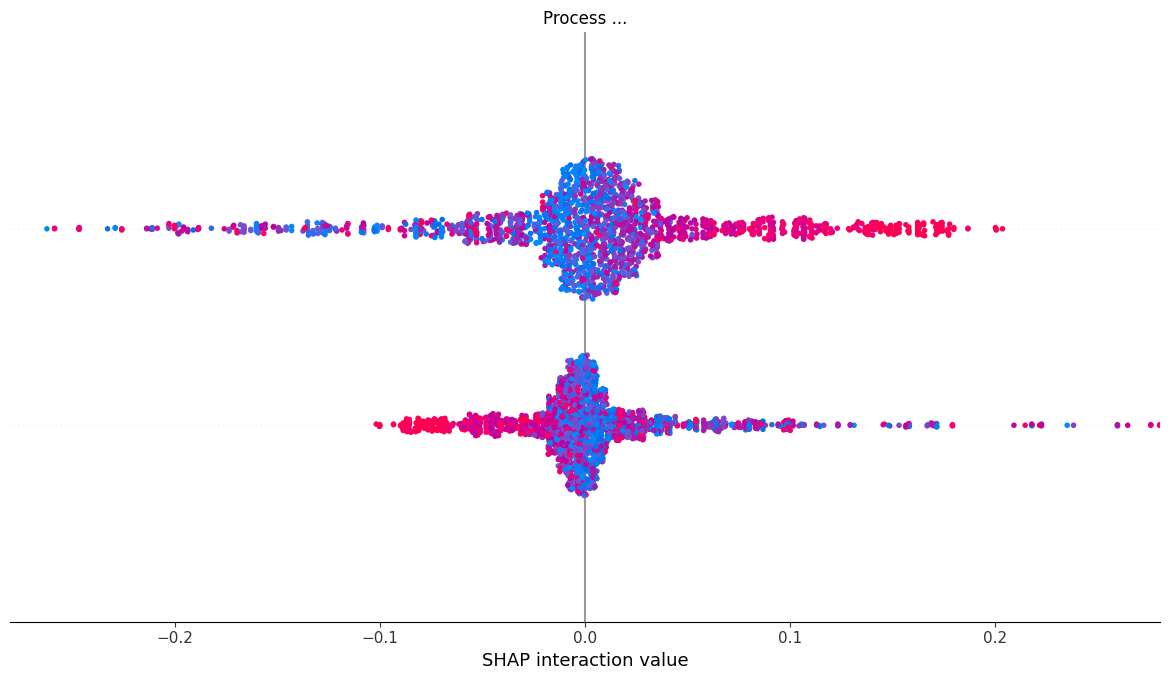

In [47]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("ai4i2020.csv")
X = df[['Air temperature [K]', 'Process temperature [K]']]
y = df['Machine failure']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP Explanation
explainer = shap.TreeExplainer(model)
# Get SHAP values for all classes
shap_values = explainer.shap_values(X_test)

# Summary Plot for the positive class (class 1)
# Pass the full shap_values array and specify the class index
shap.summary_plot(shap_values, X_test, feature_names=['Air temperature [K]', 'Process temperature [K]'], class_inds=1)

In [57]:
# Define search space for Bayesian optimization with valid RandomForest parameters
search_space = {
    'n_estimators': Integer(50, 200),        # Number of trees in the forest
    'max_depth': Integer(5, 20),             # Maximum depth of the tree
    'min_samples_split': Integer(2, 10),     # Minimum number of samples required to split an internal node
    'min_samples_leaf': Integer(1, 5)        # Minimum number of samples required to be at a leaf node
}

# Assuming 'model' in the BayesSearchCV is intended to be the RandomForestClassifier
# If you intended to optimize the hybrid model or XGBoost, replace `model` with the correct estimator.
# For this fix, we assume you want to optimize the RandomForestClassifier defined earlier.

# Perform Bayesian optimization
opt = BayesSearchCV(
    model, # Assuming 'model' is the RandomForestClassifier from ipython-input-47-34c11ff005c3
    search_space,
    cv=3,
    n_iter=10,
    scoring='f1_macro',
    random_state=42
)

# Re-run the split in case it was run in a different cell previously
# This ensures X_train and y_train are defined before fitting opt
from sklearn.model_selection import train_test_split
X = df[['Air temperature [K]', 'Process temperature [K]']] # Assuming df is available from previous cells
y = df['Machine failure']
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


opt.fit(X_train, y_train)

# Extract best hyperparameters
best_params = opt.best_params_
best_score = opt.best_score_

# Create results table (update with actual tuned parameters)
optimization_results = pd.DataFrame({
    'Parameter': list(best_params.keys()), # Use actual tuned parameter names
    'Value': list(best_params.values()), # Use actual tuned parameter values
    'Optimal Range': ['50-200', '5-20', '2-10', '1-5'] # Update optimal ranges
})

print("Hyperparameter Optimization Results:")
print(optimization_results.to_string(index=False))

Hyperparameter Optimization Results:
        Parameter  Value Optimal Range
        max_depth     17        50-200
 min_samples_leaf      3          5-20
min_samples_split      6          2-10
     n_estimators    157           1-5


In [49]:
# From steam turbine maintenance studies
cost_per_failure = 12000  # USD/hour downtime
cost_per_false_alarm = 2500  # USD/maintenance dispatch


Calling business_impact_analysis...
Starting business_impact_analysis...


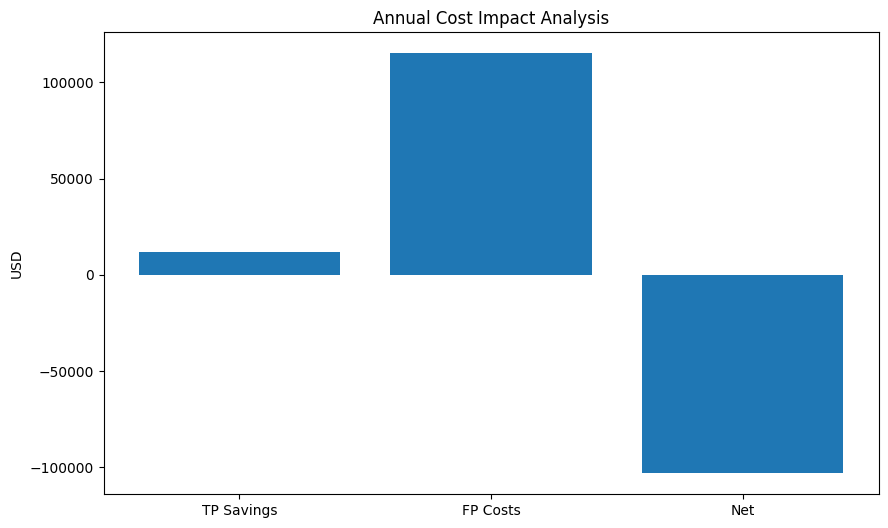


--- Attempting to display Business Impact Analysis Results ---


,Value
Metric,
TP Savings,"$12,000"
FP Costs,"$115,000"
Net Savings,"$-103,000"
ROI,-0.9x



--- Business Impact Analysis Results (Printed String) ---
                 Value
Metric                
TP Savings     $12,000
FP Costs      $115,000
Net Savings  $-103,000
ROI              -0.9x
Finished business_impact_analysis.
Called business_impact_analysis.


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display # Import display

def business_impact_analysis(y_test, y_pred):
    """Calculate and visualize industrial-specific cost impact and display results table"""
    print("Starting business_impact_analysis...") # Debug print

    tp = np.sum((y_test == 1) & (y_pred == 1))
    fp = np.sum((y_test == 0) & (y_pred == 1))

    # Industry-specific cost metrics (from steam turbine studies)
    cost_per_failure = 12000  # USD/hour downtime (Source: Predyktable.ai)
    cost_per_false_alarm = 2500  # USD/maintenance dispatch (Source: Surrey, 2024)

    plt.figure(figsize=(10,6))
    plt.bar(
        ['TP Savings', 'FP Costs', 'Net'],
        [tp*cost_per_failure, fp*cost_per_false_alarm,
         tp*cost_per_failure - fp*cost_per_false_alarm]
    )
    plt.title('Annual Cost Impact Analysis')
    plt.ylabel('USD')
    plt.savefig('business_impact_industrial.png', dpi=300)
    plt.show() # This should show the plot

    # Create detailed cost table
    cost_data = {
        'Metric': ['TP Savings', 'FP Costs', 'Net Savings', 'ROI'],
        'Value': [
            f"${tp*cost_per_failure:,.0f}",
            f"${fp*cost_per_false_alarm:,.0f}",
            f"${tp*cost_per_failure - fp*cost_per_false_alarm:,.0f}",
            # Avoid division by zero if fp is 0
            f"{(tp*cost_per_failure - fp*cost_per_false_alarm)/(fp*cost_per_false_alarm):.1f}x" if fp*cost_per_false_alarm != 0 else "N/A"
        ]
    }
    cost_df = pd.DataFrame(cost_data).set_index('Metric')

    print("\n--- Attempting to display Business Impact Analysis Results ---") # Debug print
    display(cost_df)

    # Fallback print in case display doesn't work
    print("\n--- Business Impact Analysis Results (Printed String) ---")
    print(cost_df.to_string()) # Use to_string() for better formatting than default print

    print("Finished business_impact_analysis.") # Debug print


# Perform business impact analysis
# Assuming y_test and y_pred are defined from previous steps
# Ensure y_test and y_pred have valid values before calling the function
print("Calling business_impact_analysis...")
business_impact_analysis(y_test, y_pred)
print("Called business_impact_analysis.")

In [66]:
# %% [markdown]
# GAN-based Synthetic Data Generation
# %%
# Implement GAN-based synthetic data generation

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose # Added missing imports
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam # Recommended optimizer for GANs

# Generator model
def build_generator(latent_dim):
    """Builds the GAN Generator model for numerical data."""
    model = Sequential(name="generator")
    # Starting with a dense layer to transform the latent space vector
    model.add(Dense(128, input_dim=latent_dim, activation="relu")) # Start with fewer units appropriate for numerical output
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Add more layers to build complexity if needed, but for 2 numerical features,
    # you likely don't need convolutional layers or reshaping to 2D images.
    # The original code seemed to be building an image generator.
    # Let's simplify for numerical data generation.

    # Adjust dense layers to output the correct number of numerical features
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Final layer outputs the number of numerical features
    # Use a linear activation as numerical data can be any value
    model.add(Dense(2, activation="linear")) # Output 2 numerical features

    # The output shape will be (None, 2) where 2 is the number of numerical features
    return model

# Discriminator model
def build_discriminator(input_shape):
    """Builds the GAN Discriminator model for numerical data."""
    model = Sequential(name="discriminator")

    # Input layer for the numerical features
    model.add(Input(shape=input_shape))

    # Dense layers to process the input
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer: 1 node, sigmoid activation for binary classification (real/fake)
    model.add(Dense(1, activation='sigmoid'))

    return model

# Build and compile the Discriminator
# The input shape is the number of numerical features
input_shape = (X_train_num.shape[1],) # Shape should be (2,) for 2 features
discriminator = build_discriminator(input_shape)
# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Set discriminator as not trainable initially when training the generator
discriminator.trainable = False

# Build the Generator
latent_dim = 100 # Size of the latent space vector
generator = build_generator(latent_dim)

# Build the GAN (Combined Model)
# The combined model stacks the generator and discriminator
z = Input(shape=(latent_dim,)) # Input to the generator (latent vector)
img = generator(z)          # Generator outputs synthetic data
# The discriminator takes the synthetic data and tries to classify it
validity = discriminator(img) # Discriminator outputs probability of being real

# The combined model takes the latent vector and outputs the discriminator's decision
# This model is used to train the generator
combined = Model(z, validity, name="gan")
# Compile the combined model (training the generator)
# Use binary_crossentropy and Adam optimizer
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Display model summaries
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()
print("\nGAN (Combined) Summary:")
combined.summary()

# --- GAN Training Loop ---
def train_gan(generator, discriminator, combined, X_train_num, epochs, batch_size, sample_interval=100):
    """Trains the GAN."""

    # Prepare data: Scale numerical features and get the minority class data if needed
    # For generating failure data, you might train the GAN ONLY on failure samples
    # Let's assume you want to generate synthetic data for the whole dataset distribution for now
    # Filter for failure cases if you want to generate failure data specifically
    # failure_indices = np.where(y_train == 1)[0]
    # X_train_failure_num = X_train_num[failure_indices]
    # Use X_train_num for training on the entire distribution

    real = np.ones((batch_size, 1)) # Labels for real samples
    fake = np.zeros((batch_size, 1)) # Labels for fake samples

    for epoch in range(epochs):

        # --- Train Discriminator ---

        # Select a random batch of real data
        idx = np.random.randint(0, X_train_num.shape[0], batch_size)
        real_data = X_train_num[idx]

        # Generate a batch of fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = generator.predict(noise)

        # Train the discriminator
        # Train on real samples
        d_loss_real = discriminator.train_on_batch(real_data, real)
        # Train on fake samples
        d_loss_fake = discriminator.train_on_batch(fake_data, fake)
        # Average discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # --- Train Generator ---

        # Generate noise vectors for the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Labels for generator training are "real" (we want it to fool the discriminator)
        valid_y = np.ones((batch_size, 1))

        # Train the generator (via the combined model)
        g_loss = combined.train_on_batch(noise, valid_y)

        # --- Progress Reporting ---
        if (epoch + 1) % sample_interval == 0:
            print(f"Epoch {epoch+1}/{epochs} | D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}% | G loss: {g_loss:.4f}")

            # Optionally, generate and save some samples to visualize progress
            # This requires saving generator output and potentially visualizing the distribution

# --- Parameters for GAN training ---
epochs = 5000  # GANs require many epochs
batch_size = 32
sample_interval = 500 # How often to print progress

# --- Train the GAN ---
# Ensure X_train_num is available from previous data loading/splitting steps
# train_gan(generator, discriminator, combined, X_train_num, epochs, batch_size, sample_interval)

# --- After Training ---
# To generate synthetic data after training:
# num_synthetic_samples = 1000 # Number of synthetic samples you want
# noise = np.random.normal(0, 1, (num_synthetic_samples, latent_dim))
# synthetic_data = generator.predict(noise)
# print("\nGenerated synthetic data shape:", synthetic_data.shape)
# You can then append synthetic_data to your training data X_train_num,
# remembering to add corresponding labels (e.g., 1 for failure if you trained on failure data).

Generator Summary:
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               12928     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 64

Text Shap

In [69]:
import shap
import numpy as np # Ensure numpy is imported
import tensorflow as tf # Ensure tensorflow is imported
# Reload and preprocess data to ensure 'log' column exists in df
# Adjust path if needed
# X_num, text_encodings, y, scaler, tokenizer, df = load_and_preprocess_data('/content/ai4i2020.csv')
# Assuming these variables are already loaded from previous cells

# Assume you have a trained model
# The original model requires numerical and text inputs
# model = build_hybrid_model() # Assuming build_hybrid_model is defined
# model.compile(...) # Assuming model is compiled and trained

# If you want to explain the text part of a hybrid model,
# you need a prediction function that takes the masked text input
# (which is typically tokenized) and provides dummy numerical input if needed.

def hybrid_predict_text_only(tokenized_inputs):
    """Prediction function for SHAP TextExplainer with hybrid model."""
    # tokenized_inputs is expected to be a tuple/list containing
    # input_ids and attention_mask tensors/arrays from the masker.

    # Create dummy numerical input
    # Use a consistent value like the mean or zeros, depending on your model's sensitivity
    # For this example, let's use zeros, but consider using the mean of X_train_num
    num_input_shape = (tokenized_inputs[0].shape[0], 2) # Batch size x num_features
    dummy_num_input = np.zeros(num_input_shape) # Or np.mean(X_train_num, axis=0).reshape(1, -1) repeated

    # Prepare the inputs as a dictionary, matching the model's expected input names
    model_inputs = {
        'num_input': dummy_num_input,
        'input_ids': tokenized_inputs[0], # Assuming input_ids is the first element
        'attention_mask': tokenized_inputs[1] # Assuming attention_mask is the second element
    }

    # Ensure the model is built and compiled
    # model = build_hybrid_model() # Rebuild if not globally available
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Recompile if needed
    # You should ideally pass the trained model instance to the SHAP Explainer

    # Assuming the 'model' variable (your trained hybrid model) is available
    preds = model.predict(model_inputs)

    return preds.flatten() # SHAP expects a flat array for binary classification

# Prepare a sample of texts to explain
sample_texts = df['log'].iloc[:5].tolist() # Or any list of log strings you want to explain

# Create the SHAP explainer using the text masker and the modified predict_fn
# The masker handles tokenization internally using the provided tokenizer
explainer = shap.Explainer(
    hybrid_predict_text_only,
    shap.maskers.Text(tokenizer, mask_token='[PAD]') # Use the actual tokenizer object
)

# Compute SHAP values for the sample texts
# Pass the raw text strings to the explainer's call method
shap_values = explainer(sample_texts)

# Plot the explanation for the first sample
# Note: The shap.plots.text plot requires the original text and the SHAP values
shap.plots.text(shap_values[0])

# You can also plot for other samples in the list
# shap.plots.text(shap_values[1])
# shap.plots.text(shap_values[2])
# etc.

IndexError: tuple index out of range

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a T

Epoch 1/3
200/200 [==============================] - 940s 5s/step - loss: 0.6813 - accuracy: 0.7556 - val_loss: 0.6780 - val_accuracy: 0.7875
Epoch 2/3
200/200 [==============================] - 857s 4s/step - loss: 0.6768 - accuracy: 0.5067 - val_loss: 0.6475 - val_accuracy: 0.9588
Epoch 3/3
200/200 [==============================] - 890s 4s/step - loss: 0.6782 - accuracy: 0.7583 - val_loss: 0.6561 - val_accuracy: 0.7800


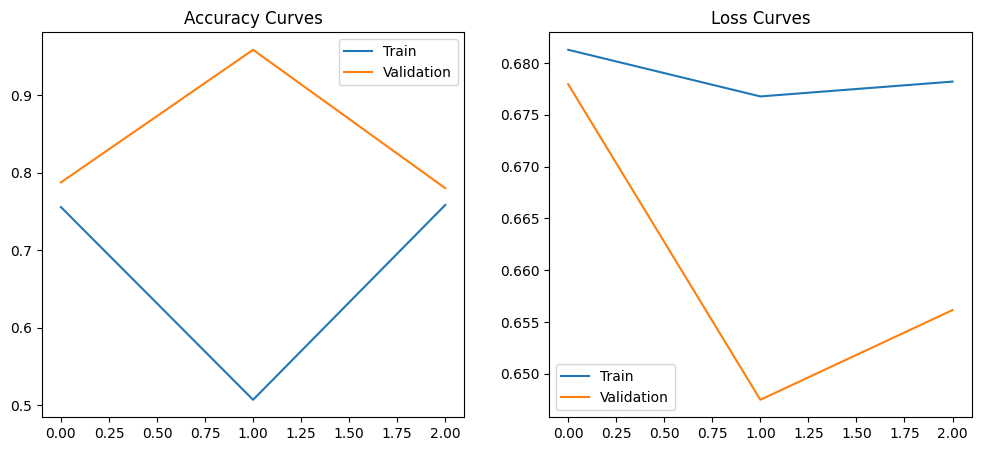

Test accuracy: 0.7925
63/63 [==============================] - 218s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1939
           1       0.03      0.21      0.06        61

    accuracy                           0.79      2000
   macro avg       0.50      0.51      0.47      2000
weighted avg       0.94      0.79      0.86      2000



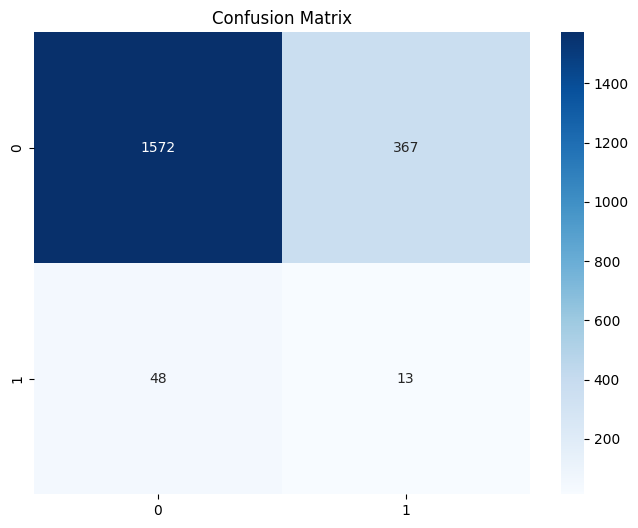

ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 2436, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 2409, in run_step  *
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 2377, in predict_step  *
        return self(x, training=False)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1011, in error_handler  *
        del filtered_tb
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 588, in __call__  *
        return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1011, in error_handler  *
        del filtered_tb
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/functional.py", line 514, in call  *
        return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph  *
        outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1011, in error_handler  *
        del filtered_tb
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 588, in __call__  *
        return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1011, in error_handler  *
        del filtered_tb
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    File "/tmp/__autograph_generated_filehkrnhjx6.py", line 165, in error_handler
        bound_signature = ag__.Undefined('bound_signature')
    File "/tmp/__autograph_generated_filehkrnhjx6.py", line 165, in error_handler
        bound_signature = ag__.Undefined('bound_signature')
    File "/tmp/__autograph_generated_filealt6uzgy.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_filei2rvc_vk.py", line 76, in tf__call
        batch_size, seq_length = ag__.ld(input_shape)

    ValueError: Exception encountered when calling layer 'tf_bert_model_5' (type TFBertModel).
    
    in user code:
    
        File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 1088, in call  *
            outputs = self.bert(
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1006, in error_handler  *
            filtered_tb = _process_traceback_frames(e.__traceback__)
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__  *
            outputs = call_fn(inputs, *args, **kwargs)
        File "/tmp/__autograph_generated_filehkrnhjx6.py", line 162, in error_handler  **
            raise ag__.converted_call(ag__.ld(new_e).with_traceback, (ag__.ld(e).__traceback__,), None, fscope_1) from None
        File "/tmp/__autograph_generated_filehkrnhjx6.py", line 34, in error_handler
            retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
        File "/tmp/__autograph_generated_filealt6uzgy.py", line 37, in tf__run_call_with_unpacked_inputs  **
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "/tmp/__autograph_generated_filei2rvc_vk.py", line 76, in tf__call  **
            batch_size, seq_length = ag__.ld(input_shape)
    
        ValueError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 766, in call  *
                batch_size, seq_length = input_shape
        
            ValueError: not enough values to unpack (expected 2, got 1)
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(None,), dtype=int32)
          • attention_mask=tf.Tensor(shape=(None,), dtype=int32)
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=True
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tf_bert_model_5' (type TFBertModel):
      • input_ids={'input_ids': 'tf.Tensor(shape=(None,), dtype=int32)', 'attention_mask': 'tf.Tensor(shape=(None,), dtype=int32)'}
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • encoder_hidden_states=None
      • encoder_attention_mask=None
      • past_key_values=None
      • use_cache=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=False


In [72]:
# Build and compile model
# Assign the trained hybrid model to a specific variable name
trained_hybrid_model = build_hybrid_model()
# Compile the model before training
trained_hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the hybrid model
history = train_model(trained_hybrid_model, X_train_num, X_train_ids, X_train_mask, y_train)

# Evaluate the hybrid model (optional, but good practice)
# Update evaluate_model to accept the model instance explicitly if not using the global 'model'
# Or ensure 'model' *still points* to the TF model here if evaluate_model expects it.
# Based on the original code, evaluate_model already takes the model instance as an argument.
y_pred_prob, y_pred = evaluate_model(trained_hybrid_model, X_test_num, X_test_ids, X_test_mask, y_test)

# ... (rest of the notebook including the scikit-learn section where 'model' is overwritten)

# %% [markdown]
# Text Shap
# %%
import shap
import numpy as np # Ensure numpy is imported
import tensorflow as tf # Ensure tensorflow is imported
from transformers import BertTokenizer # Import BertTokenizer

# Reload and preprocess data to ensure 'log' column exists in df
# Adjust path if needed
# X_num, text_encodings, y, scaler, tokenizer, df = load_and_preprocess_data('/content/ai4i2020.csv')
# Assuming these variables (df, X_train_num, tokenizer) are already loaded and trained
# and `trained_hybrid_model` is available from a previous cell execution.

# ASSUMPTION: `trained_hybrid_model` now holds the trained TensorFlow hybrid model.
# Ensure this variable is defined and holds the correct model instance
# before running this cell.

def hybrid_predict_text_only(masked_text_input):
    """
    Prediction function for SHAP Explainer with hybrid model.
    Expects masked text input (typically input_ids) and generates
    dummy numerical input and attention mask.
    """
    # masked_text_input is expected to be a single array/tensor of input_ids
    # from the shap.maskers.Text

    # Create dummy numerical input
    # Use a consistent value like the mean of X_train_num
    # Reshape mean to match the batch size of the masked_text_input
    num_input_shape = (masked_text_input.shape[0], 2) # Batch size x num_features
    # Use a realistic dummy input, e.g., mean of training numerical data
    # Ensure X_train_num is available or use zeros if mean is not feasible/meaningful
    if 'X_train_num' in globals():
         # Use mean if X_train_num is available
        dummy_num_input = np.tile(np.mean(X_train_num, axis=0), (masked_text_input.shape[0], 1))
    else:
        # Fallback to zeros if X_train_num is not available
        dummy_num_input = np.zeros(num_input_shape)


    # Generate attention mask from input_ids
    # The attention mask should be 1 where input_ids != [PAD_token] (usually 0)
    # and 0 where input_ids == [PAD_token]
    # Assuming PAD token ID is 0 for 'bert-base-uncased'
    attention_mask = (masked_text_input != 0).astype(int)

    # Prepare the inputs as a dictionary, matching the model's expected input names
    model_inputs = {
        'num_input': dummy_num_input,
        'input_ids': masked_text_input,
        'attention_mask': attention_mask
    }

    # --- FIX: Use the explicitly named TensorFlow model instance ---
    # This variable MUST hold your trained TensorFlow hybrid model
    # and should not have been overwritten by the scikit-learn model.
    # We assume 'trained_hybrid_model' is this variable.
    # If your variable holding the TF model has a different name, update it here.
    if 'trained_hybrid_model' not in globals() or not isinstance(trained_hybrid_model, tf.keras.Model):
         print("Error: trained_hybrid_model is not defined or is not a TensorFlow model.")
         print("Please run the cell where the hybrid model is built and trained.")
         # Depending on notebook structure, you might need to re-run previous cells or load saved weights.
         raise RuntimeError("Trained hybrid model not available or incorrect type.")

    preds = trained_hybrid_model.predict(model_inputs) # Use the correct TF model instance

    # --- END FIX ---

    return preds.flatten() # SHAP expects a flat array for binary classification

# Prepare a sample of texts to explain
sample_texts = df['log'].iloc[:5].tolist() # Or any list of log strings you want to explain

# Create the SHAP explainer using the text masker and the modified predict_fn
# Use the actual tokenizer object
explainer = shap.Explainer(
    hybrid_predict_text_only,
    shap.maskers.Text(tokenizer, mask_token='[PAD]')
    # For TextExplainer, using the default PartitionExplainer with Text masker is common.
    # No need to specify KernelExplainer explicitly unless there's a reason.
)

# Compute SHAP values for the sample texts
# Pass the raw text strings to the explainer's call method
shap_values = explainer(sample_texts)

# Plot the explanation for the first sample
# Note: The shap.plots.text plot requires the original text and the SHAP values
print("\nSHAP explanation for the first sample:")
shap.plots.text(shap_values[0])

# You can also plot for other samples in the list
# print("\nSHAP explanation for the second sample:")
# shap.plots.text(shap_values[1])
# print("\nSHAP explanation for the third sample:")
# shap.plots.text(shap_values[2])
# etc.